## Управление ориентацией самолетов с неподвижным крылом с использованием Q-Learning 

Постановка задачи: В начале эпизода самолет отклоняется от горизонтально траектории и от агента требуется вернуть самолет в изначальное положение, используя базовые элементы управления: тангаж и крен, эпизд заканчивается, когда угловые координаты самолета (Roll, Ritch) находятся в окрестности нуля.

Количество состояний описывается следующим алгоритмом:

Разделим полуинтервал от [-180;180) на 13 частей: [-180; -75), [-75;-35), [-35, -15), [-15, -5), [-5, -2), [-2, -1), [-1, 1), [1, 2), [2, 5), [5, 15), [15, 35), [35, 75), [75, 180) и будем говорить, если угол попал в интервал i то он будет иметь бин i, так как угла два $\to$ получается два бина соответственно по двум бинам и определяется состояние системы. через формулу:

$$s_i = 13\phi_i + \theta_i$$ 

Действием в данной задаче является отклонения руля тангажа и крена на некоторую величину, которая меняется от -1 до 1 для каждого элемента управления. Для выбора действия предоставляется следующее разбиение(предсталенно разбиение полуинтервала от [-180, 0) так как при положительном угла знак действия будет менятся):

In [63]:
table = [
    ["[-180, -50)", 0.75],
    ["[-50, -25)", 0.66],
    ["[-25, -15)", 0.50],
    ["[-15, -5)", 0.33],
    ["[-5, -2)", 0.1],
    ["[-2, -1)", 0.05],
    ["[-1, 0)", 0.025]
]
import pandas as pd
pd.DataFrame(table, columns=["Полуинтервал", "Значение отнлонения"])

,Полуинтервал,Значение отнлонения
0,"[-180, -50)",0.750
1,"[-50, -25)",0.660
2,"[-25, -15)",0.500
3,"[-15, -5)",0.330
4,"[-5, -2)",0.100
5,"[-2, -1)",0.050
6,"[-1, 0)",0.025


Как можно видеть у агента есть две возможности отклонения руля для каждого угла. Так что в итоге набор действий будет таким:
* отклонить руль тангажа\крена на большую величену
* отклонить руль тангажа\крена на меньшую величину
* отклонить и руль тангажа и руль крена на (б, м), (б,б), (м, б), (м, м) для тангажа и крена соответственно, гда б - большая величина,
таким образом 8 вариантов

Награда: Награда определяется после каждого действия, считываев два угла, определяющих положение самолета, и вычисляем награда, кроме того размер награды зависит  

$$r=(2 - (\frac{|\phi|}{180}+\frac{|\theta|}{180}))^2$$ 

    со следующим пенальти:

$$ r = r * 0.1 ~~if |\theta|, |\phi| > 40 \newline r = r * 0.25 ~~if |\theta|, |\phi| \in [20,40] \newline r = r * 0.5  ~~if |\theta|, |\phi| \in [10,20] \newline r = r * 0.75~~  if |\theta|, |\phi| \in [5,10] \newline r = r * 0.9  ~~if |\theta|, |\phi| \in [1,5]  $$


В данной задаче будем использовать Q-learning. Используя функции вознограждения он обучается и в конце представляетс наилучшие действия согласно модели.
 
По сути, Q-learning позволяет агенту использовать вознаграждения среды, чтобы со временем научиться наилучшим действиям в данном состоянии.

Для нашей задачи вознаграждения дается настолько больше, насколько близко агент сумеет привести самолет к нулевым Roll и Pitch

Значения запомненного вознаграждения, будем хранить в Q-таблице - словарем состояние+действие = значение, тем самым происходит обучение.

Q-значения инициализируются произвольным значением, и по мере того, как агент подвергается воздействию окружающей среды и получает различные вознаграждения за выполнение различных действий, Q-значения обновляются с использованием уравнения:

$$ Q(s, a) \leftarrow (1 - \alpha)Q(s, a) + \alpha(r + \gamma \max\limits_{a} Q(s_n, n_a) $$

Где:

- $\alpha$ - это скорость обучения ($0 < \alpha \leq 1$) - Так же, как и в условиях контролируемого обучения, это степень, с которой наши значения Q обновляются на каждой итерации.

- $\gamma$ - коэффициент скидки ($ 0 \leq \gamma \leq 1$) - определяет, затухание вознаграждения, чем больше итераций, тем меньше награда за верное решение.

In [64]:
import jsbsim
import numpy as np
from math import pi

# управляет действиями
class Actions:
    def __init__(self) -> None:
        self.table = {"sustation" : [i for i in range(169)], "position":[]}
        for i in range(13):
            for j in range(13):
                self.table["position"].append((i,j))
        # массивы с помощью которых определяется действия значение по двум полученым углам
        self.avalible_segments = [-180, -75, -35, -15, -5, -2,-1, 1, 2, 5, 15, 35, 75, 180]
        self.avalible_segments2 = [-1, -2, -5, -10, -15, -25, -50, -180]
        self.actions = [0.025, 0.05, 0.1, 0.25, 0.33, 0.5, 0.66, 0.75]
        self.fdm = jsbsim.FGFDMExec(None)
        self.fdm.disable_output()
        self.good_steps_counter = 0

    def Reset(self):
        self.fdm = jsbsim.FGFDMExec(None)
        self.fdm.disable_output()
        self.fdm.load_script("scripts/c172_cruise_8K.xml", False)
        self.fdm["ic/theta-deg"] = (np.random.random() * (2) - 1) * 15
        self.fdm["ic/phi-deg"] = (np.random.random() * (2) - 1) * 15
        self.fdm.run_ic()
        return self.Get_state()

    def change_roll(self, angle:float):
        self.fdm["fcs/aileron-cmd-norm"] = angle

    def change_pitch(self, angle:float):
        self.fdm["fcs/elevator-cmd-norm"] = angle

    def Get_roll(self):
        return self.fdm["attitude/roll-rad"] * 180*2/pi
    
    def Get_pitch(self):
        return self.fdm["attitude/pitch-rad"] * 180*2/pi

    def _get_bin(self, angle:float) -> int:
        for i in range(len(self.avalible_segments) - 1):
            if self.avalible_segments[i] <= angle < self.avalible_segments[i+1]:
                return i
        return 12
    def Get_state(self):
        roll = self.Get_roll()
        pitch = self.Get_pitch()
        return self.table["sustation"][(self._get_bin(roll) * 13 + self._get_bin(pitch))]

    def Get_actions(self) -> list:
        roll = self.Get_roll()
        pitch = self.Get_pitch()
        sign = (lambda a: 1 if a > 0 else -1)
        roll_actions = (0, 0)
        pitch_actions = (0, 0)
        for i in range(len(self.avalible_segments2)):
            if abs(roll) < abs(self.avalible_segments2[i]):
                try:
                    roll_actions = np.array([self.actions[i] *  sign(roll), self.actions[i+1] *sign(roll)])
                    # roll_actions = np.append(roll_actions, -1*roll_actions)
                except:
                    roll_actions = np.array([self.actions[i] *  -sign(roll), self.actions[i-1] * -sign(roll)])
                    # roll_actions = np.append(roll_actions, -1*roll_actions)
                break

        for i in range(len(self.avalible_segments2)):
            if abs(pitch) < abs(self.avalible_segments2[i]):
                try:
                    pitch_actions = np.array([self.actions[i] *  sign(pitch), self.actions[i+1] *sign(pitch)])
                    # pitch_actions = np.append(pitch_actions, -1*pitch_actions)
                except:
                    pitch_actions = np.array([self.actions[i] *  sign(pitch), self.actions[i-1] *sign(pitch)])
                    # pitch_actions = np.append(pitch_actions, -1*pitch_actions)
                break

        return [("roll", i) for i in roll_actions] + \
               [("pitch", i) for i in pitch_actions] +\
               [("double", i, j) for i in pitch_actions for j in roll_actions] 
               



    def reward(self):
        roll = self.Get_roll()
        pitch = self.Get_pitch()
        r = (2 - ((abs(roll)/180 + abs(pitch)/180)/2) ** 2)
        if abs(roll) > 40 or abs(pitch) > 40:
            return r * 0.1
        elif abs(roll) > 20 or abs(pitch) > 20:
            return r * 0.25
        elif abs(roll) > 10 or abs(pitch) > 10:
            return r * 0.5
        elif abs(roll) > 5 or abs(pitch) > 5:
            return r * 0.75
        elif abs(roll) > 1 or abs(pitch) > 1:
            return r * 0.9
        else:
            return 1
    
    def Step(self, tup):
        if tup[0] == "double":
            self.change_roll(tup[1])
            self.change_pitch(tup[2])
        elif tup[0] == "roll":
            self.change_roll(tup[1])
        else:
            self.change_pitch(tup[1])
        reward = self.reward()
        done = False
        if self.Get_roll() > 1 or self.Get_roll() < -1 or self.Get_pitch() > 1 or self.Get_pitch() < -1:
            self.good_steps_counter = 0
        else:
            self.good_steps_counter += 1

        if self.good_steps_counter == 100:
            done = True
            self.good_steps_counter = 0
        # done = (lambda Roll, Pitch: True if -1 < Roll and Roll > 1\
        #     and -1 < Pitch and Pitch > 1 else False) (self.Get_roll(), self.Get_pitch())
        return self.Get_state(), reward, done
    
import math


In [65]:
r = np.array([0,1])
d = (2,3)

print(np.append(d, -r))

[ 2  3  0 -1]


In [66]:
from collections import defaultdict
import numpy as np
import time

class QLearningAgent:
   
    def __init__(self, alpha, epsilon, gamma, actions:Actions) -> None:
        self._q_values = defaultdict(lambda: defaultdict(lambda : 0))
        self.alpha = alpha # lr = 0.01
        self.gamma = gamma # gamma = 0.95
        self.epsilon = epsilon #eps = 0.5
        self.actions = actions

    def Set_q_value(self, state, action, value):
        self._q_values[state][action] = value

    def Get_q_value(self, state, action):
        return self._q_values[state][action]

    def Get_value(self):
        actions = self.actions.Get_actions()
        state = self.actions.Get_state()
        value = max([self.Get_q_value(state, action) for action in actions])
        return value

    def Policy(self):
        state = self.actions.Get_state()
        actions = self.actions.Get_actions()
        best_action = actions[0]
        for action in actions:
            if self.Get_q_value(state, action) > self.Get_q_value(state, best_action):
                best_action = action
        return best_action
            

    def Get_action(self):
        actions = self.actions.Get_actions()
        if np.random.random() < self.epsilon:
            action = actions[np.random.choice([i for i in range(len(actions))], 1)[0]]
        else:
            action = self.Policy()
        return action
    
    def Update(self, state, action, reward):
        self.epsilon -= 0.00001
        addition = self.alpha*(reward + self.gamma *(self.Get_value()-self.Get_q_value(state, action)))
        reference_value = self.Get_q_value(state, action) + addition
        self.Set_q_value(state, action, reference_value)


In [67]:
from collections import deque
from tqdm import tqdm

pitch_0 = []
roll_0 = []


def interact(acts:Actions, agent:QLearningAgent, num_episodes=20):
    average_reward_per_100_episodes = []
    best_average_reward_per_100_episodes = []
    avg_rewards = deque(maxlen=num_episodes)
    best_avg_reward = -math.inf
    rewards = deque(maxlen=5000)

    for episode in tqdm(range(num_episodes)):
        state = acts.Reset()
        
        counter = 0
        curr_reward = 0
        agent.epsilon = 1
        while acts.fdm.run():
            counter += 1    
            if episode == 0:
                pitch_0.append(acts.Get_pitch())
                roll_0.append(acts.Get_roll())
            action = agent.Get_action()
            next_state, reward, done = acts.Step(action)
            agent.Update(next_state, action, reward)
            curr_reward += reward
            state = next_state
            if done:
                rewards.append(curr_reward)
                break
          
        if episode % 1000 == 0:
            avg_reward = np.mean(rewards)
            avg_rewards.append(avg_reward)
            print('episode average reward {}'.format(avg_reward))
            average_reward_per_100_episodes.append(avg_reward)
            best_average_reward_per_100_episodes.append(best_avg_reward)
            
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                
            print("\rEpisode {}/{} || Best average reward {} || eps {} ".format(episode, num_episodes, best_avg_reward, agent.epsilon), end="")
    return avg_rewards, best_avg_reward

acts = Actions()
qlearn = QLearningAgent(0.01, 0.5, 1, acts)
avg_rewards, best_avg_reward = interact(acts, qlearn)

  5%|▌         | 1/20 [00:03<01:15,  3.97s/it]

episode average reward 10368.082123649132
Episode 0/20 || Best average reward 10368.082123649132 || eps 0.6612100000015418 

 30%|███       | 6/20 [00:38<01:31,  6.50s/it]

In [ ]:
import time

acts.Reset()
pitch = []
roll = []
while acts.fdm.run():
    roll.append(acts.Get_roll())
    pitch.append(acts.Get_pitch())
    action = qlearn.Get_action()
    next_state, reward, done = acts.Step(action)
    qlearn.Update(next_state, action, reward)
    state = next_state
    if done:
        break
    state = next_state


In [ ]:
print(roll_0)


[5.325436343368283, 5.325464165089125, 5.325541175532015, 5.325674582565599, 5.32587156223941, 5.326139259669779, 5.326484789412416, 5.32691528824163, 5.327437853622857, 5.328059527500321, 5.328787316985984, 5.329628195238886, 5.330589114229746, 5.331676983423651, 5.332898670784002, 5.3342610145583285, 5.3357708225991045, 5.337434868748347, 5.33925991488862, 5.341252687498493, 5.3434198586258805, 5.345768089234324, 5.348304025396328, 5.351034276080714, 5.353965414120832, 5.35710395199373, 5.360456356095108, 5.364029063123382, 5.367828479722405, 5.37186098262363, 5.376132918782104, 5.38065060551205, 5.3854203306216135, 5.390448352547089, 5.395740900486395, 5.401304174532069, 5.407144345803405, 5.413267561114363, 5.419679970581025, 5.426387670517364, 5.433396711977158, 5.440713120538893, 5.44834289177707, 5.456291991584175, 5.464566357703914, 5.473171899815634, 5.482114499662993, 5.491400011181826, 5.501034260627337, 5.511023046700608, 5.521372140674637, 5.532079937049019, 5.543152185994

In [ ]:
print(pitch_0)

[-28.993402591585273, -28.987766598403763, -28.976040870556275, -28.95695366716312, -28.925491903307282, -28.87811408626145, -28.81235747082966, -28.72691644119397, -28.621332723263386, -28.49540760833957, -28.348775265965774, -28.180954416737638, -27.99174604046768, -27.78115897648654, -27.54935577377902, -27.296612623871845, -27.02328773104872, -26.72979929360532, -26.41661135078814, -26.084311618879255, -25.733488124161195, -25.364730228601193, -24.978624405176586, -24.575751937328786, -24.156693609496845, -23.72203007640405, -23.272341857101665, -22.80821082837317, -22.330215859520347, -21.838938909287588, -21.334959499026848, -20.818853856129994, -20.29144934605943, -19.753297830180745, -19.204947897438213, -18.64694671707356, -18.079839879597575, -17.504173246284164, -16.920484018569084, -16.329301756142897, -15.732010053199902, -15.129901250232235, -14.524033982604676, -13.91531246379933, -13.304507018220868, -12.69228650412811, -12.079235197251776, -11.465880401864526, -10.8526

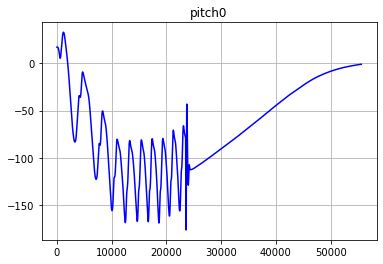

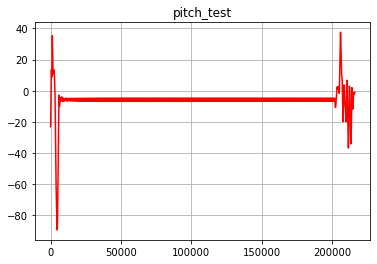

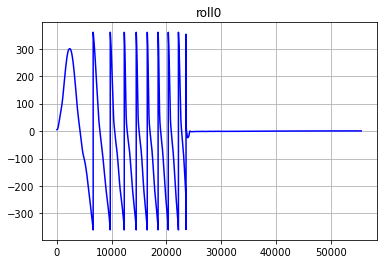

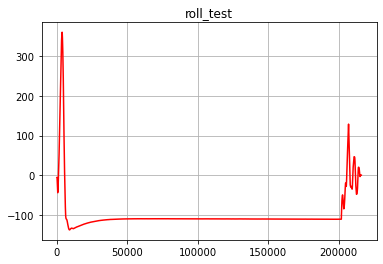

In [ ]:
import matplotlib.pyplot as plt

colors = ["b", "g", "r"]

plt.figure(1)
plt.plot(np.arange(len(pitch_0)), pitch_0, c='b')
plt.title("pitch0")
plt.grid()
plt.show()

plt.figure(2)
plt.plot(np.arange(len(pitch)), pitch, c='r')
plt.title("pitch_test")
plt.grid()
plt.show()

plt.figure(3)
plt.plot(np.arange(len(roll_0)), roll_0, c='b')
plt.title("roll0")
plt.grid()
plt.show()

plt.figure(4)
plt.plot(np.arange(len(roll)), roll, c='r')
plt.title("roll_test")
plt.grid()
plt.show()